PART 1

We know from the soft em derivation in module 4 that $\left(\gamma\left(z_{n,k}\right)\ =\ p\left(z_{n,k}=1\right|d_n\theta^{old}\right)$

In hard EM each data point is assigned to a class which has the largest posterior probability. So $\left(Z^{ }\ =\ \arg\max_z\gamma\left(z_{n,k}\right)\ =\ \arg\max_zp\left(z_{n,k}=1\right|d_n\theta^{old}\right)$

And as there isn't any expectation on the latent variables in the definition of the Q function, we get $\left(Q\left(\theta,\theta^{old}\right)\ =\ \sum_{n=1}^N\ln p\left(z_{n,k=z}=1\right|d_n\theta^{ }\right)$

The E Step: If the stop cond. isn't met then, we will on the basis of parameters $\theta^{old}=\left(\varphi^{old},\mu_1^{old},\mu_2^{old},\mu_3^{old}....\mu_K^{old}\right)\ $, we will make n and k to z like $\left(Z^{ }\ =\ \arg\max_z\gamma\left(z_{n,k}\right)\ =\ \arg\max_zp\left(z_{n,k}=1\right|d_n\theta^{old}\right)$

In the end will get the following for the cluster: $\varphi_k^{new}=\frac{N_k}{N}and\ N_k=\sum_{n=1}^Nz_{n,k=z},\ $also for in the cluster the words: $\ \mu_{k,w}^{new}=\frac{\sum_{n=1}^Nz_{n,k=z}c\left(w,d_n\right)}{\sum_{w'\in\varrho}^{ }\sum_{n=1}^Nz_{n,k=Z}c\left(w',d_n\right)}$

PART 2

In [49]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer

with open('Task2A.txt', 'r') as file:
    text = file.readlines()
all([len(line.split('\t')) == 2 for line in text])
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]
docs = pd.DataFrame(data=zip(labels, articles), columns=['label', 'article'])
docs['label'] = docs['label'].astype('category')
cv = CountVectorizer(lowercase=True, stop_words='english', min_df=5)
features = cv.fit_transform(raw_documents=articles)
l2_norm = Normalizer(norm='l2')
features = l2_norm.fit_transform(features)
counts = features.toarray().T  # Transposing the matrix features

In [60]:
import numpy as np

class HardEM:
    def __init__(self, counts, K=4, max_epoch=10):  #intializing the class variables 
        self.counts = counts
        self.K = K
        self.max_epoch = max_epoch

    def intials(self, vocab_size):
        h = np.full((self.K, 1), 1/self.K)#Initializing h
        ll = np.random.rand(self.K, vocab_size)#Generating random values for the ll matrix
        ll = ll / ll.sum(axis=1)[:, np.newaxis]
        return {"h": h, "ll": ll}

    def lnsum(self, j):
        mx = np.max(j)#finding the max value in j
        return mx+np.log(np.sum(np.exp(j - mx)))#log of the sum of exp after subtracting the max j from j

    def E_step(self, gamma, model):
        N = self.counts.shape[1]#Getting the number of columns
        K = model["ll"].shape[0]#Getting the number of rows
        for n in range(N)::#Looping through each columns
            for k in range(K):
                gamma[n, k] = np.log(model["h"][k, 0]) + np.sum(self.counts[:, n] * np.log(model["ll"][k, :]))#Calculating the value of gamma
            logZ=self.lnsum(gamma[n,:])#Calculating the logarithm of the sum of gamma values for row n
            gamma[n,:]=gamma[n,:]-logZ#Subtracting logZ from each element of the gamma row
        gamma=np.exp(gamma)#applying the exp func to all elements of gamma
        z=np.argmax(gamma, axis=1)#finding the index with the max value in each row of gamma
        return z

    def M_step(self, gamma_z, model):
        N = self.counts.shape[1]#Getting the number of columns
        W1 = self.counts.shape[0]#Getting the number of rows
        K = model["ll"].shape[0]#Getting the number of rows in ll matrix
        eps = 1e-10 * np.ones((W1, N))
        z = gamma_z
        for b in range(K):#lopping through each row in ll matrix
            model["h"][b, 0] = np.sum(z==b)/N#Updating h values for b
            model["ll"][b, :]=np.sum(self.counts[:,z==b]+eps[:,z==b],axis=1)/np.sum(np.sum(self.counts[:,z==b]+eps[:,z==b]))#Calculating the updated values for ll matrix
        return model

    def train(self):
        N = self.counts.shape[1]#Getting the number of columns
        W1 = self.counts.shape[0]#Getting the number of rows
        model = self.intials(W1)
        gamma = np.zeros((N, self.K))
        print(self.train2(model))
        for epoch in range(self.max_epoch):#lopping through the number of epoch choosen
            kmax = self.E_step(gamma, model)#Performing the E-step and obtaining the value of kmax
            model = self.M_step(kmax, model)#Updating the model parameters using the M-step
            print(self.train2(model))
        return {"model": model, "k_max": kmax}

    def train2(self, model):
        nl = 0 #Initializing the negative log-likelihood to 0
        N = self.counts.shape[1]#Getting the number of columns
        K = model["ll"].shape[0]#Getting the number of rows in ll matrix
        for t in range(N):#Looping through each columns
            p = np.zeros((K, 1))#Initializing p
            for k in range(K):#Looping through each row
                p[k, 0]=np.sum(self.counts[:, t]*np.log(model["ll"][k, :]))#Calculating the value of p for each each row and coluumn
            nl -= self.lnsum(p+np.log(model["h"]))#Updating the negative log-likelihood
        return nl

In [61]:
class SoftEM:
    def __init__(self, counts, K=4, max_epoch=10): #intializing the class variables
        self.counts = counts
        self.K = K
        self.max_epoch = max_epoch

    def intials(self, vocab_size):
        h = np.full((self.K, 1), 1/self.K)#Initializing h
        ll = np.random.rand(self.K, vocab_size)#Generating random values for the ll matrix
        ll = ll / ll.sum(axis=1)[:, np.newaxis]
        return {"h": h, "ll": ll}

    def lnsum(self,j):
        mx=np.max(j)#finding the max value in j
        return mx+np.log(np.sum(np.exp(j-mx)))#log of the sum of exp after subtracting the max j from j

    def E_step(self, gamma, model):  #defining the E Step
        N = self.counts.shape[1]#Getting the number of columns
        K = model["ll"].shape[0]#Getting the number of rows of ll matrix
        for n in range(N):
            for k in range(K):
                gamma[n, k] = np.log(model["h"][k, 0]) + np.sum(self.counts[:, n] * np.log(model["ll"][k, :]))#Calculating the value of gamma
            logZ = self.lnsum(gamma[n, :])#Calculating the logarithm of the sum of gamma values for row n
            gamma[n, :] = gamma[n, :] - logZ#Subtracting logZ from each element of the gamma row
        gamma = np.exp(gamma)#applying the exp func to all elements of gamma
        return gamma

    def M_step(self, gamma, model): #defining the M Step
        N = self.counts.shape[1]#Getting the number of columns
        W = self.counts.shape[0]#Getting the number of rows
        K = model["ll"].shape[0]#Getting the number of rows of ll matrix
        eps = 1e-10 * np.ones((W, N))
        for k in range(K):
            model["h"][k, 0] = np.sum(gamma[:, k]) / N#Updating h values for b
            model["ll"][k, :] = (np.dot(self.counts, gamma[:, k]) + eps[:, k]) / np.sum(np.dot(self.counts, gamma[:, k]) + eps[:, k]) #Calculating the updated values for ll matrix
        return model

    def train(self): 
        N = self.counts.shape[1]
        W = self.counts.shape[0]
        model = self.intials(W)
        gamma = np.zeros((N, self.K))
        print(self.train2(model))
        for epoch in range(self.max_epoch):#lopping through the number of epoch choosen
            gamma = self.E_step(gamma, model)#Performing the E-step and obtaining the value of gamma
            model = self.M_step(gamma, model)#updating the model parameters using the M-step
            print(self.train2(model))
        return {"model": model, "gamma": gamma}

    def train2(self, model):
        N = self.counts.shape[1]#Getting the number of columns
        K = model["ll"].shape[0]#Getting the number of rows of ll matrix
        nl = 0 #Initializing the negative log-likelihood to 0
        for n in range(N):#Looping through each column
            p=np.zeros((K, 1))#Initializing p
            for k in range(K):#Looping through each row
                p[k, 0]=np.sum(self.counts[:,n] * np.log(model["ll"][k,:]))#Calculating the value of p for each each row and coluumn
            nl -= self.lnsum(p+np.log(model["h"]))#Updating the negative log-likelihood
        return nl



PART 3

In [62]:
hard_em = HardEM(counts, K=4)
result = hard_em.train()

159546.3798776229
139136.7784140713
138699.73112398898
138369.35012313578
138195.4447483905
138107.4275563999
138053.68051055347
138025.38282703512
138015.2749258123
138003.92084183768
138003.64051776537


In [63]:
soft_em = SoftEM(counts, K=4)
result1 = soft_em.train()

159584.51153854086
138949.59168869926
138624.96686836446
137925.0972739677
136904.48003995442
136080.2641576206
135561.5019287946
135269.95053034514
135105.05848157508
134970.0957540366
134850.39990621596


PART 4

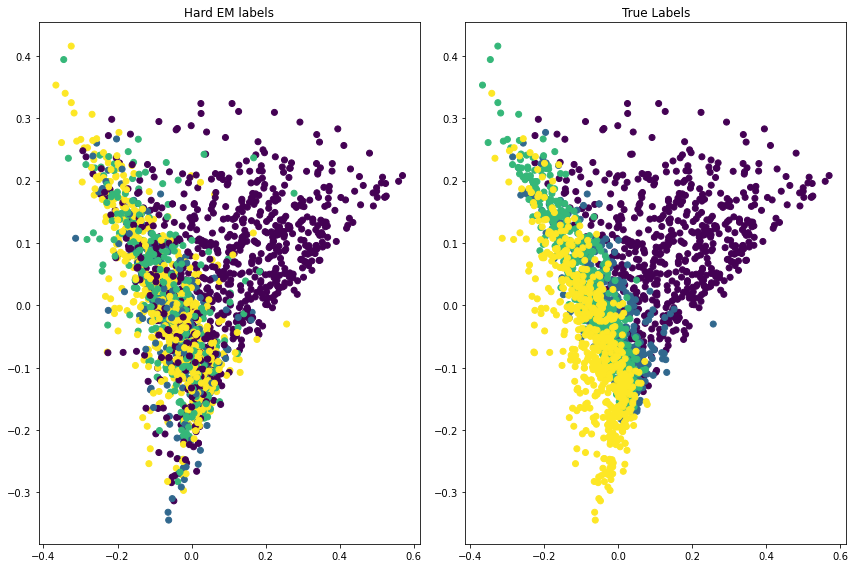

In [64]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features.toarray())
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=result['k_max'])
axs[0].set_title('Hard EM labels')
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Labels')
plt.show()

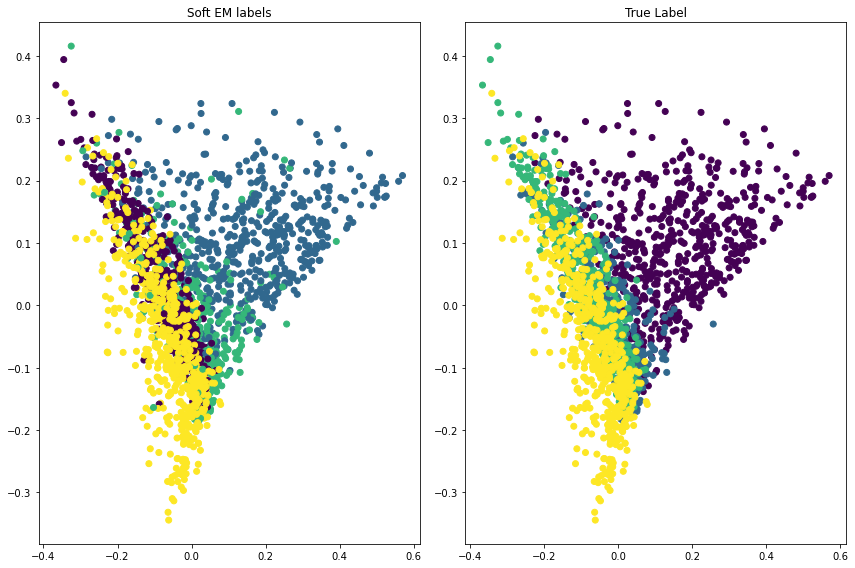

In [65]:
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=np.argmax(result1['gamma'],axis=1))
axs[0].set_title('Soft EM labels')
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Label')
plt.show()

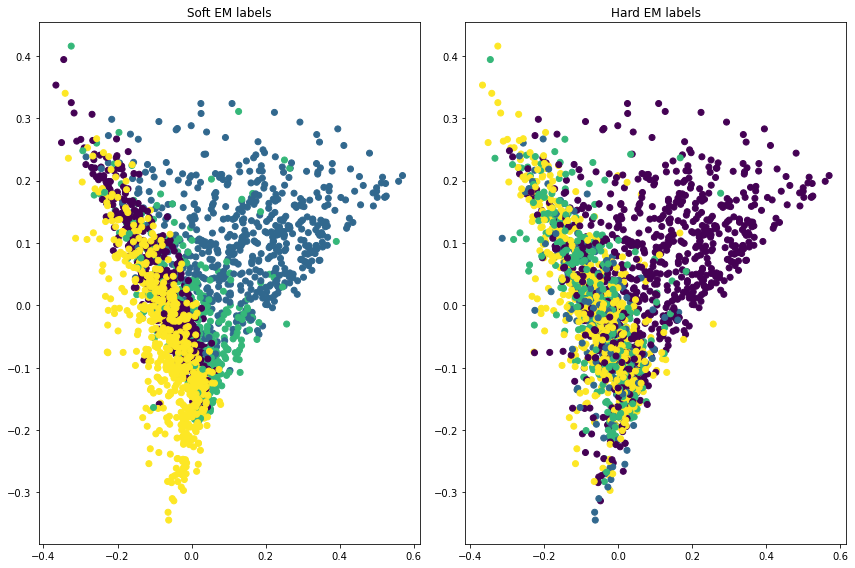

In [66]:
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=np.argmax(result1['gamma'],axis=1))
axs[0].set_title('Soft EM labels')
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=result['k_max'])
axs[1].set_title('Hard EM labels')
plt.show()

After plotting the clusters for hard-EM and soft-EM we can observe the differences due to the following reasons:
1. Hard-EM assigns each document to a single cluster with a high degree of confidence so we observe well-defined clusters with minimal data points close to cluster boundaries. Also Hard-EM is usally more sensitive to outliers.
2. Soft-EM assigns documents to clusters with probabilities which allows for documents to have multiple cluster assignments. We observe data points closer to cluster boundaries, reflecting uncertainty in assignments. Also it is more robust to outliers and can capture subtle relationships.

Here Hard EM is probably not able to capture the subtle relationships between the parameters so is giving a bad result here.

References: https://github.com/Agewerc/Expectation-Maximization-Document-Clustering/blob/master/EM-document-clustering.ipynb